In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lichess_code 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)

In [4]:
df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games_20.csv")
df=lichess_code.add_total_accuracy(df)
summary_table=lichess_code.create_summary_table(df)

In [5]:
# Assuming 'df' contains the columns 'GameID', 'Player', and 'Total_Accuracy'

# Remove duplicates to ensure one entry per player per game
df_unique = df[['GameID', 'Player', 'Total_Accuracy']].drop_duplicates()

# Sort the DataFrame by 'Total_Accuracy' in ascending order
df_sorted = df_unique.sort_values('Total_Accuracy', ascending=True)

# Get the top 5 entries with the lowest Total_Accuracy scores
lowest_5 = df_sorted.head(10) 

# Display the GameIDs, Players, and their Total_Accuracy scores
print("Games with the lowest 5 Total_Accuracy scores:")
print(lowest_5[['GameID', 'Player', 'Total_Accuracy']])


Games with the lowest 5 Total_Accuracy scores:
          GameID Player  Total_Accuracy
2681862  32558.0  White       20.136249
2681863  32558.0  Black       20.654277
2127283  25795.0  White       21.030625
1176119  13972.0  White       23.551820
1176120  13972.0  Black       23.962847
1743347  20900.0  Black       25.168910
698622    8381.0  White       25.608673
2684903  32610.0  Black       25.882547
2684902  32610.0  White       26.433581
1979376  23777.0  Black       27.888580


In [6]:
low_elo = summary_table[ (summary_table['Elo'] <= 1500)]
low_elo.head()

,GameID,Year,Opening,Variation,Result,TotalMoves,Player,Name,Elo,FideId,Total_Accuracy
632,317.0,2021.0,Ruy Lopez,fianchetto defence deferred,0-1,64.0,White,"Polukhin,Sergey",1410.0,24252018.0,90.158296
635,318.0,2021.0,Queen's Pawn,Unknown,1-0,39.0,Black,"Iljin,Viktor",1066.0,34413472.0,76.550521
650,334.0,2021.0,Sicilian,Grand Prix attack,1/2-1/2,66.0,White,"Polukhin,Sergey",1410.0,24252018.0,89.908060
655,336.0,2021.0,King's pawn opening,Unknown,1-0,116.0,Black,"Iljin,Viktor",1066.0,34413472.0,88.716945
664,343.0,2021.0,French,exchange variation,1/2-1/2,94.0,White,"Polukhin,Sergey",1410.0,24252018.0,89.976157


In [7]:
lichess_code.export_game_to_pgn(df,317,'../game1.pgn')

In [9]:
top_100_openings = summary_table['Opening'].value_counts().nlargest(50).index.tolist()
summary_table['Opening'] = summary_table['Opening'].apply(lambda x: x if x in top_100_openings else 'Other')

new_summary_table = summary_table[summary_table['Player'] == 'White'].copy()
#new_summary_table = new_summary_table[ (new_summary_table['TotalMoves'] <= 60)]

In [14]:
def linear_regression_model(summary_table, categorical_features, numerical_features, test_size=0.2, random_state=42):
   
    # Prepare the feature matrix X and target vector y
    features = categorical_features + numerical_features
    X = summary_table[features]
    y = summary_table['Elo']

    # Handle missing values
    X = X.fillna(0)
    y = y.fillna(0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Create a ColumnTransformer to encode categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'  # Keep numerical features as is
    )

    # Create a pipeline that first transforms the data then applies Linear Regression
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'R-squared Score (R²): {r2:.2f}')

    # Optional: Get the coefficients of the model
    # Get feature names after one-hot encoding
    onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    # Combine with numerical feature names
    feature_names = np.concatenate([onehot_feature_names, numerical_features])

    # Get coefficients from the model
    coefficients = pipeline.named_steps['regressor'].coef_

    # Create a DataFrame to display feature names and their coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Display the coefficients
    print("\nCoefficients of the model:")
    print(coef_df)

    return 


In [15]:
# Example usage:
# Define your categorical and numerical features
categorical_features = ['Opening', 'Variation', 'Result']
numerical_features = ['Total_Accuracy', 'TotalMoves']

# Call the function with your summary_table DataFrame
linear_regression_model(new_summary_table, categorical_features, numerical_features)

Root Mean Squared Error (RMSE): 247.75
R-squared Score (R²): 0.19

Coefficients of the model:
                        Feature  Coefficient
0    Opening_Alekhine's defence   -36.392511
1       Opening_Benko's opening    28.443602
2                Opening_Benoni    45.830858
3        Opening_Benoni defence    54.999182
4        Opening_Bird's opening  -137.587287
..                          ...          ...
964                  Result_1-0    45.204569
965               Result_1-0 ff    -6.729408
966              Result_1/2-1/2    31.694066
967              Total_Accuracy     6.957316
968                  TotalMoves     0.256796

[969 rows x 2 columns]


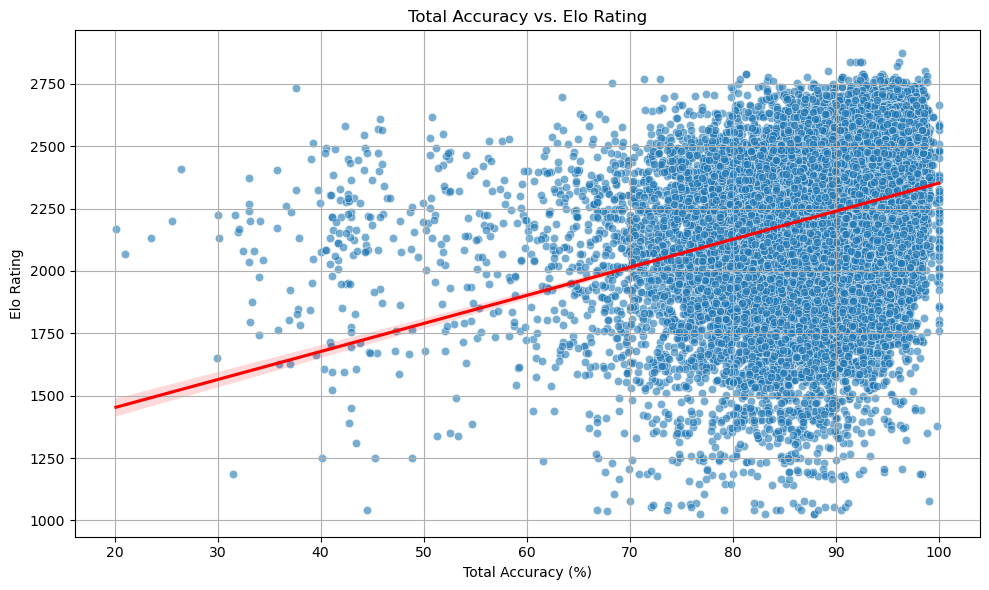

In [12]:
plot_data = new_summary_table.dropna(subset=['Total_Accuracy', 'Elo'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='Total_Accuracy', y='Elo', alpha=0.6)

# Add a regression line
sns.regplot(data=plot_data, x='Total_Accuracy', y='Elo', scatter=False, color='red')

# Customize the plot
plt.title('Total Accuracy vs. Elo Rating')
plt.xlabel('Total Accuracy (%)')
plt.ylabel('Elo Rating')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1390918/171376250.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_accuracy_per_elo_bin = data.groupby('EloBin')['Total_Accuracy'].mean().reset_index()


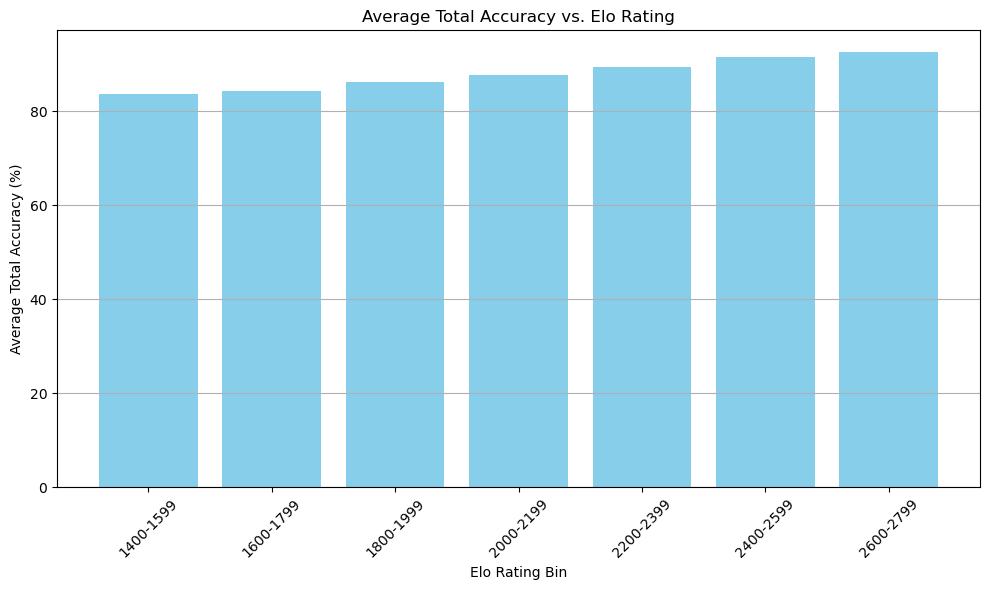

In [13]:

# Remove any rows with missing 'Elo' or 'Total_Accuracy'
data = new_summary_table.dropna(subset=['Elo', 'Total_Accuracy']).copy()

# Ensure 'Elo' is numeric
data['Elo'] = pd.to_numeric(data['Elo'], errors='coerce')

# Create Elo bins and labels
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]

elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1]
    upper = upper - 1  # Subtract 1 to make the upper limit inclusive
    label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)

# Assign Elo bins to the data
data['EloBin'] = pd.cut(
    data['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False  # Left-inclusive intervals
)

# Remove any rows where 'EloBin' is NaN (in case 'Elo' is outside the bins)
data = data.dropna(subset=['EloBin'])

# Compute average Total Accuracy per Elo bin
avg_accuracy_per_elo_bin = data.groupby('EloBin')['Total_Accuracy'].mean().reset_index()

# Sort the bins in order
avg_accuracy_per_elo_bin['EloBin'] = pd.Categorical(avg_accuracy_per_elo_bin['EloBin'], categories=elo_labels, ordered=True)
avg_accuracy_per_elo_bin = avg_accuracy_per_elo_bin.sort_values('EloBin')

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(avg_accuracy_per_elo_bin['EloBin'], avg_accuracy_per_elo_bin['Total_Accuracy'], color='skyblue')
plt.title('Average Total Accuracy vs. Elo Rating')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Total Accuracy (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()